# ML Task - Predicting LOS using window and PySpark

Start with the necessary imports...

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lag, col, avg, hour, dayofweek, dayofmonth, month, year
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit


import matplotlib.pyplot as plt
import pandas as pd


import os

Define necessary PySpark env variables.

In [2]:
#os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-17-openjdk-amd64'
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-21-openjdk-21.0.3.0.9-1.fc40.x86_64/'
os.environ['SPARK_LOCAL_IP'] = '127.0.0.1'
os.environ['SPARK_MASTER_HOST'] = 'localhost'

Building the spark session...

In [3]:
spark = SparkSession.builder \
    .appName("Setup") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.host","127.0.0.1") \
    .config("spark.driver.bindAddress","127.0.0.1") \
    .getOrCreate()
sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/21 16:35:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/06/21 16:36:00 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Read the previously processed data.

In [4]:
file_path = "dataset/DS.parquet"

ds = spark.read.format("parquet") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load(file_path)

ds.printSchema()
ds.show(5)

root
 |-- SUBJECT_ID: integer (nullable = true)
 |-- HADM_ID: integer (nullable = true)
 |-- LOS: double (nullable = true)
 |-- SEQ_NUM: integer (nullable = true)
 |-- TOTAL_EVENTS: long (nullable = true)
 |-- AGE_AT_ADMISSION: integer (nullable = true)
 |-- ADMITTIME: timestamp (nullable = true)
 |-- GENDER: double (nullable = true)
 |-- ADMISSION_TYPE: double (nullable = true)
 |-- MULTIPLE_ADMISSIONS: integer (nullable = true)
 |-- MULTIPLE_ICU_STAYS: integer (nullable = true)

+----------+-------+------+-------+------------+----------------+-------------------+------+--------------+-------------------+------------------+
|SUBJECT_ID|HADM_ID|   LOS|SEQ_NUM|TOTAL_EVENTS|AGE_AT_ADMISSION|          ADMITTIME|GENDER|ADMISSION_TYPE|MULTIPLE_ADMISSIONS|MULTIPLE_ICU_STAYS|
+----------+-------+------+-------+------------+----------------+-------------------+------+--------------+-------------------+------------------+
|       295| 192988|0.9057|      2|        1246|              61|2176-03-

In [5]:
ds.describe().show()

24/06/21 16:36:03 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------------+------------------+-----------------+-----------------+-----------------+------------------+-------------------+-------------------+-------------------+------------------+
|summary|       SUBJECT_ID|           HADM_ID|              LOS|          SEQ_NUM|     TOTAL_EVENTS|  AGE_AT_ADMISSION|             GENDER|     ADMISSION_TYPE|MULTIPLE_ADMISSIONS|MULTIPLE_ICU_STAYS|
+-------+-----------------+------------------+-----------------+-----------------+-----------------+------------------+-------------------+-------------------+-------------------+------------------+
|  count|            19891|             19891|            19891|            19891|            19891|             19891|              19891|              19891|              19891|             19891|
|   mean|38194.28098134835|149954.20411241264|3.747975958976436| 8.50273993263285|5724.020360967272| 66.76144990196572|0.43426675380825497|0.23498064451259362| 0.3134080740033181|0.3832386506460208|
| std

# Models

We train and evaluate three different regression models (Linear Regression, Decision Tree Regressor and Gradient-Boosted Trees Regressor) to predict LOS.

Select the following features for our models:

In [6]:
features = ["TOTAL_EVENTS", "AGE_AT_ADMISSION", "GENDER", "ADMISSION_TYPE", "MULTIPLE_ADMISSIONS", "MULTIPLE_ICU_STAYS", "SEQ_NUM"]
target = "LOS"

The dataset is split into training and testing sets (80% training, 20% testing), and a `VectorAssembler` is used to assemble the feature columns into a single vector column named "features".

In [7]:
(train_data, test_data) = ds.randomSplit([0.8, 0.2], seed=42)

assembler = VectorAssembler(inputCols=features, outputCol="features")
train_data = assembler.transform(train_data)
test_data = assembler.transform(test_data)

In [ ]:
scaler = MinMaxScaler(inputCol="TOTAL_EVENTS", outputCol="TOTAL_EVENTS")

scaler_model = scaler.fit(train_data)
train_data = scaler_model.transform(train_data)

scaled_df.select("id", "features", "scaledFeatures").show()

The models were trained with hyperparameter tuning using a parameter grid and evaluated using Root Mean Squared Error (RMSE), R-squared (R²), Mean Absolute Error (MAE), and Mean Squared Error (MSE).

For all the models, we compute and display the performance metrics and feature importances and also visualize the actual vs. predicted values using scatter plots.

### Linear regression

In [8]:
lr = LinearRegression(featuresCol='features', labelCol=target)

paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.fitIntercept, [False, True])\
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .addGrid(lr.maxIter, [10, 100, 1000]) \
    .build()

evaluator = RegressionEvaluator(
    labelCol=target, predictionCol="prediction", metricName="rmse")

tvs = TrainValidationSplit(estimator=lr,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           trainRatio=0.8)

# Run TrainValidationSplit, and choose the best set of parameters.
lr_model = tvs.fit(train_data)

predictions = lr_model.transform(test_data)

predictions.select("features", "LOS", "prediction").show(5)

rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

evaluator.setMetricName("r2")
r2 = evaluator.evaluate(predictions)
print(f"R-squared on test data = {r2}")

evaluator.setMetricName("mae")
mae = evaluator.evaluate(predictions)
print(f"Mean Absolute Error (MAE) on test data = {mae}")

evaluator.setMetricName("mse")
mse = evaluator.evaluate(predictions)
print(f"Mean Squared Error (MSE) on test data = {mse}")

coefficients = lr_model.bestModel.coefficients
intercept = lr_model.bestModel.intercept

print("Coefficients: {}".format(coefficients))
print("Intercept: {:.2f}".format(intercept))

feature_importance = sorted(list(zip(features, map(abs, coefficients))), key=lambda x: x[1], reverse=True)

print("Feature Importance:")
for feature, importance in feature_importance:
    print("  {}: {:.3f}".format(feature, importance))

24/06/21 16:36:04 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/06/21 16:36:04 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
24/06/21 16:36:04 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


+--------------------+------+------------------+
|            features|   LOS|        prediction|
+--------------------+------+------------------+
|[4941.0,39.0,1.0,...| 3.666| 3.134302317226985|
|[1312.0,75.0,0.0,...|1.1862|1.8648656905357108|
|(7,[0,1,6],[3840....|3.5466|2.8049034826656447|
|[4732.0,72.0,0.0,...|4.3483| 3.380439907034174|
|(7,[0,1,6],[1407....|1.6412|2.0769948864006667|
+--------------------+------+------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 2.9592269123294686
R-squared on test data = 0.6334335415887618
Mean Absolute Error (MAE) on test data = 1.6416894518119376
Mean Squared Error (MSE) on test data = 8.757023918655001
Coefficients: [0.00029918150278050905,0.0,0.0,-0.035367508064153626,1.0299430021024476,-1.345585201466574,0.13193524626331904]
Intercept: 1.13
Feature Importance:
  MULTIPLE_ICU_STAYS: 1.346
  MULTIPLE_ADMISSIONS: 1.030
  SEQ_NUM: 0.132
  ADMISSION_TYPE: 0.035
  TOTAL_EVENTS: 0.000
  AGE_AT_ADMISSION: 0.00

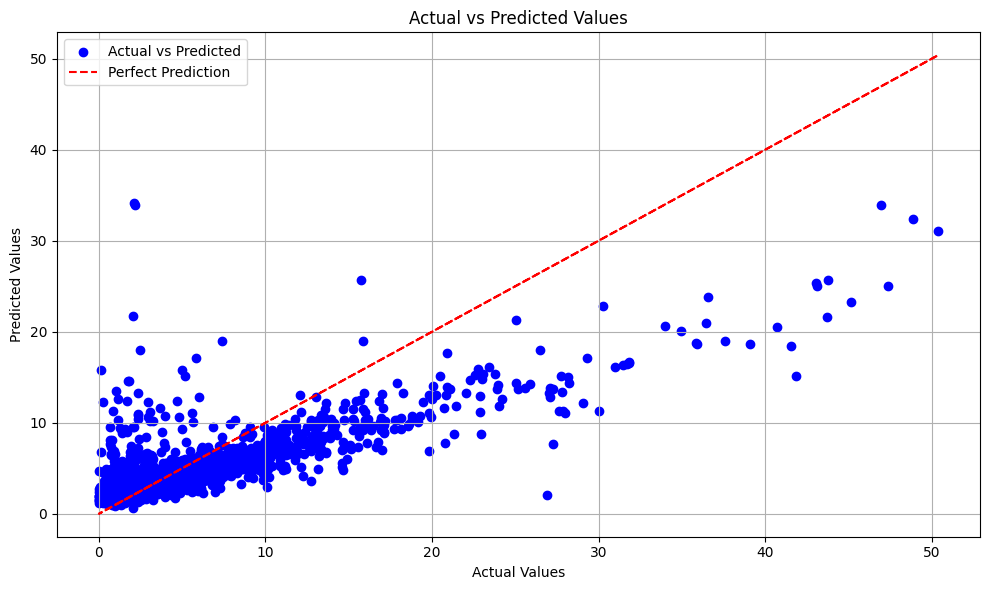

In [9]:
results = predictions.select(['prediction', target]).toPandas()

actual = results[target]
predicted = results['prediction']

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(actual, predicted, color='blue', label='Actual vs Predicted')
plt.plot(actual, actual, color='red', linestyle='--', label='Perfect Prediction')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Decision Tree Regressor

In [10]:
dt = DecisionTreeRegressor(featuresCol='features', labelCol=target)

paramGrid = ParamGridBuilder()\
    .addGrid(dt.maxDepth, [5, 10, 15]) \
    .addGrid(dt.maxBins, [20, 30])\
    .build()

evaluator = RegressionEvaluator(
    labelCol=target, predictionCol="prediction", metricName="rmse")

tvs = TrainValidationSplit(estimator=dt,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           trainRatio=0.8)

# Run TrainValidationSplit, and choose the best set of parameters.
dt_model = tvs.fit(train_data)

predictions = dt_model.transform(test_data)

predictions.select("features", "LOS", "prediction").show(20)

rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

evaluator.setMetricName("r2")
r2 = evaluator.evaluate(predictions)
print(f"R-squared on test data = {r2}")

evaluator.setMetricName("mae")
mae = evaluator.evaluate(predictions)
print(f"Mean Absolute Error (MAE) on test data = {mae}")

evaluator.setMetricName("mse")
mse = evaluator.evaluate(predictions)
print(f"Mean Squared Error (MSE) on test data = {mse}")

coefficients = dt_model.bestModel.featureImportances

print("Coefficients: {}".format(coefficients))

feature_importance = sorted(list(zip(features, map(abs, coefficients))), key=lambda x: x[1], reverse=True)

print("Feature Importance:")
for feature, importance in feature_importance:
    print("  {}: {:.3f}".format(feature, importance))

24/06/21 16:36:13 WARN DAGScheduler: Broadcasting large task binary with size 1005.2 KiB
24/06/21 16:36:14 WARN DAGScheduler: Broadcasting large task binary with size 1018.3 KiB
24/06/21 16:36:14 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+--------------------+-------+------------------+
|            features|    LOS|        prediction|
+--------------------+-------+------------------+
|[4941.0,39.0,1.0,...|  3.666| 3.967979344262288|
|[1312.0,75.0,0.0,...| 1.1862|1.6667188513513507|
|(7,[0,1,6],[3840....| 3.5466|2.9704345276872948|
|[4732.0,72.0,0.0,...| 4.3483| 3.416638338192423|
|(7,[0,1,6],[1407....| 1.6412|1.6667188513513507|
|[2690.0,76.0,1.0,...| 1.2469|1.9520511406844072|
|[3108.0,60.0,1.0,...| 3.0237|2.3853778799019643|
|[12627.0,75.0,1.0...|  7.128| 8.290930379746827|
|(7,[0,1,6],[5825....| 2.7712| 3.967979344262288|
|[2386.0,55.0,1.0,...|  2.036|2.3853778799019643|
|[21649.0,78.0,1.0...|15.2614|14.314954347826088|
|[1806.0,54.0,0.0,...| 2.0859|1.6667188513513507|
|[2061.0,44.0,0.0,...| 2.0667|1.6667188513513507|
|(7,[0,1,6],[3671....| 2.7446|2.9704345276872948|
|[18940.0,71.0,1.0...|12.8558|15.429847126436785|
|(7,[0,1,6],[2581....| 2.0323|2.3853778799019643|
|[1942.0,56.0,1.0,...| 1.3305|1.2758449026345935|


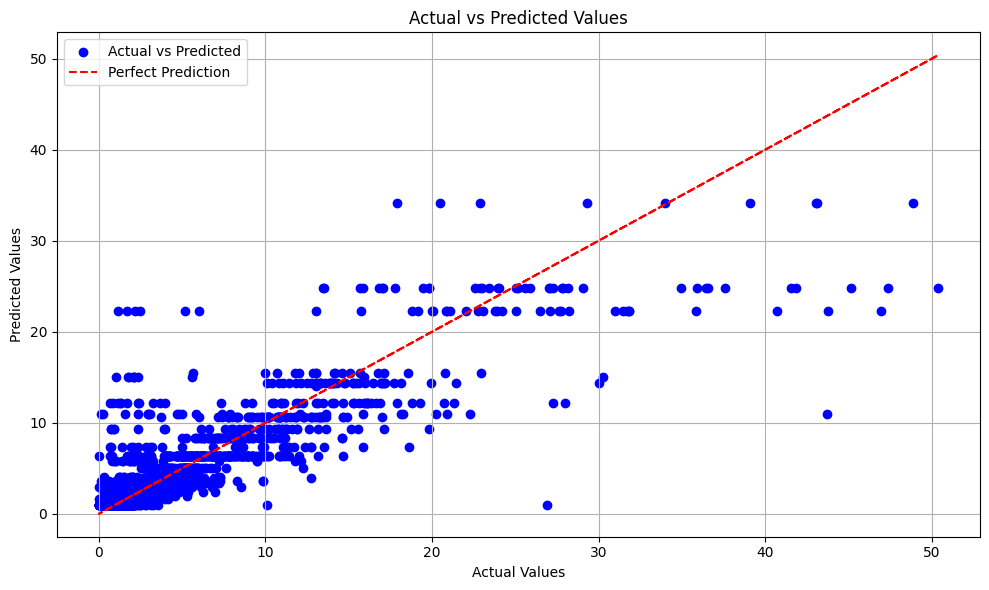

In [11]:
results = predictions.select(['prediction', target]).toPandas()

actual = results[target]
predicted = results['prediction']

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(actual, predicted, color='blue', label='Actual vs Predicted')
plt.plot(actual, actual, color='red', linestyle='--', label='Perfect Prediction')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Gradient-Boosted Trees Regressor (GBT)

In [12]:
gbt = GBTRegressor(featuresCol='features', labelCol=target)

paramGrid = ParamGridBuilder()\
    .addGrid(gbt.maxDepth, [5, 10, 15]) \
    .addGrid(gbt.maxBins, [20, 30])\
    .build()

evaluator = RegressionEvaluator(
    labelCol=target, predictionCol="prediction", metricName="rmse")

tvs = TrainValidationSplit(estimator=gbt,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           trainRatio=0.8)

# Run TrainValidationSplit, and choose the best set of parameters.
gbt_model = tvs.fit(train_data)

predictions = gbt_model.transform(test_data)

predictions.select("features", "LOS", "prediction").show(20)

rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

evaluator.setMetricName("r2")
r2 = evaluator.evaluate(predictions)
print(f"R-squared on test data = {r2}")

evaluator.setMetricName("mae")
mae = evaluator.evaluate(predictions)
print(f"Mean Absolute Error (MAE) on test data = {mae}")

evaluator.setMetricName("mse")
mse = evaluator.evaluate(predictions)
print(f"Mean Squared Error (MSE) on test data = {mse}")

coefficients = gbt_model.bestModel.featureImportances

print("Coefficients: {}".format(coefficients))

feature_importance = sorted(list(zip(features, map(abs, coefficients))), key=lambda x: x[1], reverse=True)

print("Feature Importance:")
for feature, importance in feature_importance:
    print("  {}: {:.3f}".format(feature, importance))

24/06/21 16:36:24 WARN DAGScheduler: Broadcasting large task binary with size 1014.7 KiB
24/06/21 16:36:24 WARN DAGScheduler: Broadcasting large task binary with size 1042.8 KiB
24/06/21 16:36:25 WARN DAGScheduler: Broadcasting large task binary with size 1038.1 KiB
24/06/21 16:36:25 WARN DAGScheduler: Broadcasting large task binary with size 1038.6 KiB
24/06/21 16:36:25 WARN DAGScheduler: Broadcasting large task binary with size 1039.3 KiB
24/06/21 16:36:25 WARN DAGScheduler: Broadcasting large task binary with size 1040.3 KiB
24/06/21 16:36:25 WARN DAGScheduler: Broadcasting large task binary with size 1042.6 KiB
24/06/21 16:36:25 WARN DAGScheduler: Broadcasting large task binary with size 1047.3 KiB
24/06/21 16:36:25 WARN DAGScheduler: Broadcasting large task binary with size 1055.7 KiB
24/06/21 16:36:25 WARN DAGScheduler: Broadcasting large task binary with size 1069.8 KiB
24/06/21 16:36:25 WARN DAGScheduler: Broadcasting large task binary with size 1094.1 KiB
24/06/21 16:36:25 WAR

+--------------------+-------+------------------+
|            features|    LOS|        prediction|
+--------------------+-------+------------------+
|[4941.0,39.0,1.0,...|  3.666| 4.192537893880514|
|[1312.0,75.0,0.0,...| 1.1862|1.3310025769535552|
|(7,[0,1,6],[3840....| 3.5466|2.7351334520883994|
|[4732.0,72.0,0.0,...| 4.3483|3.7525910718211057|
|(7,[0,1,6],[1407....| 1.6412|1.1855413290551085|
|[2690.0,76.0,1.0,...| 1.2469|2.1110286870695054|
|[3108.0,60.0,1.0,...| 3.0237| 2.585886696525947|
|[12627.0,75.0,1.0...|  7.128| 8.206174538878276|
|(7,[0,1,6],[5825....| 2.7712| 4.185230733029919|
|[2386.0,55.0,1.0,...|  2.036|1.9852251562881904|
|[21649.0,78.0,1.0...|15.2614|14.013152066733376|
|[1806.0,54.0,0.0,...| 2.0859|1.8545387703338523|
|[2061.0,44.0,0.0,...| 2.0667|1.9732849160980683|
|(7,[0,1,6],[3671....| 2.7446|2.9133260320440937|
|[18940.0,71.0,1.0...|12.8558|14.257223349549143|
|(7,[0,1,6],[2581....| 2.0323| 2.328186657155014|
|[1942.0,56.0,1.0,...| 1.3305| 1.376964290598226|


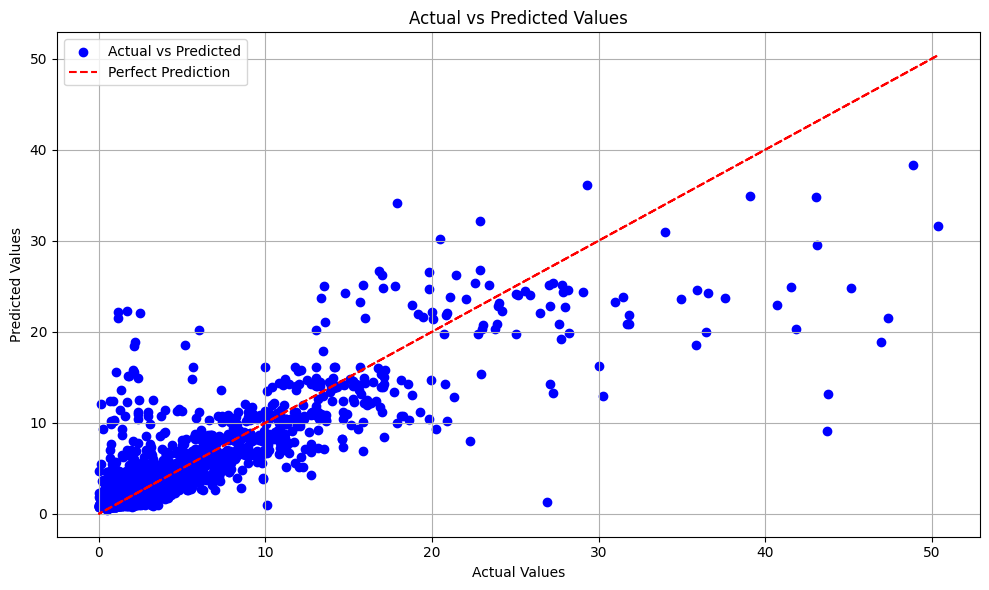

In [13]:
results = predictions.select(['prediction', target]).toPandas()

actual = results[target]
predicted = results['prediction']

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(actual, predicted, color='blue', label='Actual vs Predicted')
plt.plot(actual, actual, color='red', linestyle='--', label='Perfect Prediction')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()